# Day 17: Random Vectors

---



In [1]:
import pandas as pd 
import grama as gr 
import numpy as np

from scipy.stats import lognorm
from plotnine import *

DF = gr.Intention()


## Every summary is a *model*

---

Let's illustrate this is an example. Remember that two-minimum function we saw in the homework?


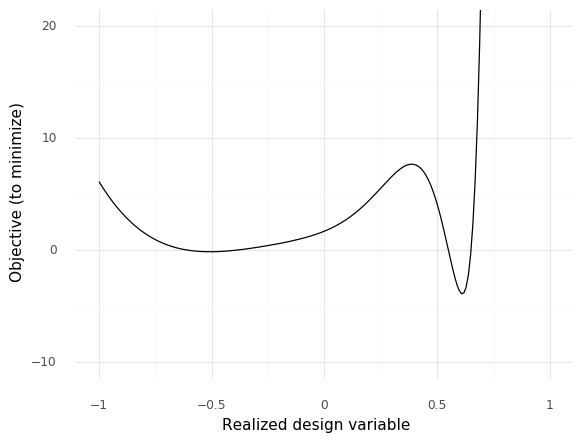

<ggplot: (8780392689649)>

In [2]:
md_poly = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=(df.x + 0.6)
             *(df.x + 0.4)
             *(df.x - 0.65)
             *(df.x - 0.55)
             *10 * (1 + np.exp(8.0 * df.x))
        ),
        var=["x"],
        out=["y"],
    )
    >> gr.cp_bounds(x=(-1, +1))
)

df_det = (
    md_poly
    >> gr.ev_df(df=gr.df_make(x=np.linspace(-1, +1, num=200)))
)

(
    df_det
    >> ggplot(aes("x", "y"))
    + geom_line()
    + coord_cartesian(ylim=(-10, +20))
    + theme_minimal()
    + labs(
        x="Realized design variable",
        y="Objective (to minimize)"
    )
)


eval_monte_carlo() is rounding n...


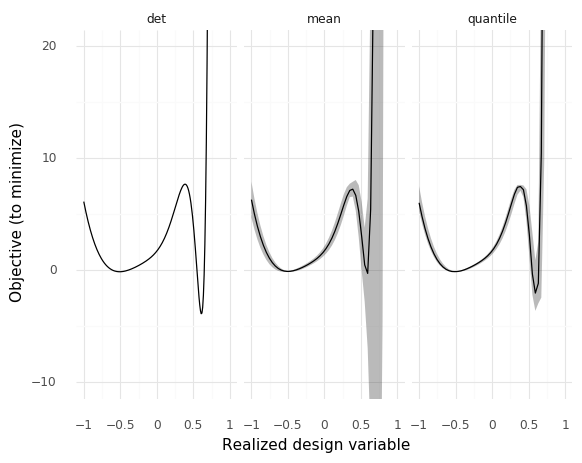

<ggplot: (8780395324569)>

In [3]:
md_poly_rand = (
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(x=df.x0 + df.dx),
        var=["x0", "dx"],
        out=["x"]
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=(df.x + 0.6)
             *(df.x + 0.4)
             *(df.x - 0.65)
             *(df.x - 0.55)
             *10 * (1 + np.exp(8.0 * df.x))
        ),
        var=["x"],
        out=["y"],
    )
    >> gr.cp_bounds(x0=(-1, +1))
    >> gr.cp_marginals(dx=dict(dist="norm", loc=0, scale=0.05))
    >> gr.cp_copula_independence()
)

df_poly_mc = (
    md_poly_rand
    >> gr.ev_monte_carlo(
        n=1e2, 
        seed=101,
        df_det=gr.df_make(x0=np.linspace(-1, +1)),
    )
)

df_qt = (
    df_poly_mc
    >> gr.tf_group_by(DF.x0)
    >> gr.tf_summarize(
        y_lo=gr.quant(DF.y, 0.25),
        y_mu=gr.quant(DF.y, 0.50),
        y_hi=gr.quant(DF.y, 0.75),
    )
    >> gr.tf_mutate(source="quantile")
)

df_sd = (
    df_poly_mc
    >> gr.tf_group_by(DF.x0)
    >> gr.tf_summarize(
        y_mu=gr.mean(DF.y),
        y_sd=gr.sd(DF.y),
    )
    >> gr.tf_mutate(
        y_lo=DF.y_mu - DF.y_sd,
        y_hi=DF.y_mu + DF.y_sd,
        source="mean",
    )
)

(
    df_det
    >> gr.tf_rename(y_mu=DF.y, x0=DF.x)
    >> gr.tf_mutate(
        y_lo=DF.y_mu,
        y_hi=DF.y_mu,
        source="det",
    )
    >> gr.tf_bind_rows(df_sd)
    >> gr.tf_bind_rows(df_qt)
    
    >> ggplot(aes("x0", "y_mu"))
    + geom_ribbon(aes(ymin="y_lo", ymax="y_hi"), alpha=1/3)
    + geom_line()
    
    + facet_wrap("source")
    + coord_cartesian(ylim=(-10, +20))
    + theme_minimal()
    + labs(
        x="Realized design variable",
        y="Objective (to minimize)"
    )
)

- This illustrates that the $\pm \sigma$ quantification is misleading; the lower bound goes far lower than is actually possible


**Principle**: Every summary is a model

The underlying model we're using with $\mu - \sigma, \mu + \sigma$ is essentially a symmetric model. Quantiles help with this specific case.

One more example: The mean of this next distribution is zero. But is that a good summary?


Design runtime estimates unavailable; model has no timing data.
Design runtime estimates unavailable; model has no timing data.
          x
0  0.013496


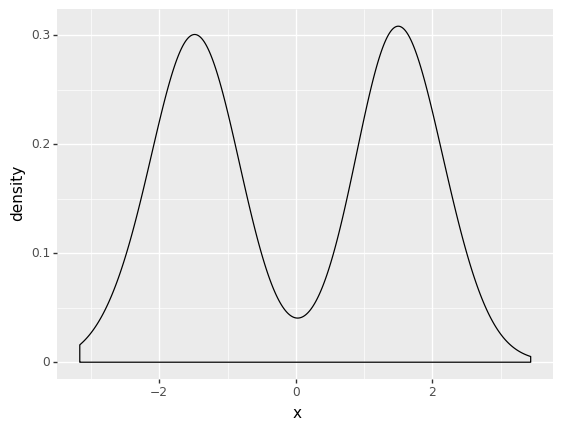

<ggplot: (8780395309297)>

In [4]:
df_mode1 = (
    gr.eval_monte_carlo(
        gr.Model()
        >> gr.cp_marginals(x=dict(dist="norm", loc=-1.5, scale=0.5))
        >> gr.cp_copula_independence(),
        n=500,
        df_det="nom",
        skip=True,
    )
)

df_mode2 = (
    gr.eval_monte_carlo(
        gr.Model()
        >> gr.cp_marginals(x=dict(dist="norm", loc=+1.5, scale=0.5))
        >> gr.cp_copula_independence(),
        n=500,
        df_det="nom",
        skip=True,
    )
)

print(
    df_mode1
    >> gr.tf_bind_rows(df_mode2)
    >> gr.tf_summarize(x=gr.mean(DF.x))
)

(
    df_mode1
    >> gr.tf_bind_rows(df_mode2)
    >> ggplot(aes("x"))
    + geom_density()
)

# Examples

---


In [6]:
from grama.models import make_prlc_rand
md_prlc = make_prlc_rand()
md_prlc


model: RLC with component tolerances

  inputs:
    var_det:
      R: [0.001, 1.0]
      L: [1e-09, 0.001]
      C: [0.001, 100]

    var_rand:
      dR: (+0) uniform, {'loc': -0.05, 'scale': 0.1}
      dL: (+0) uniform, {'loc': -0.1, 'scale': 0.2}
      dC: (+0) uniform, {'loc': -0.2, 'scale': 1.0}

    copula:
      Independence copula

  functions:
      f0: ['R', 'dR', 'L', 'dL', 'C', 'dC'] -> ['Rr', 'Lr', 'Cr']
      f1: ['Lr', 'Cr'] -> ['omega0']
      parallel RLC: ['omega0', 'Rr', 'Cr'] -> ['Q']

eval_monte_carlo() is rounding n...


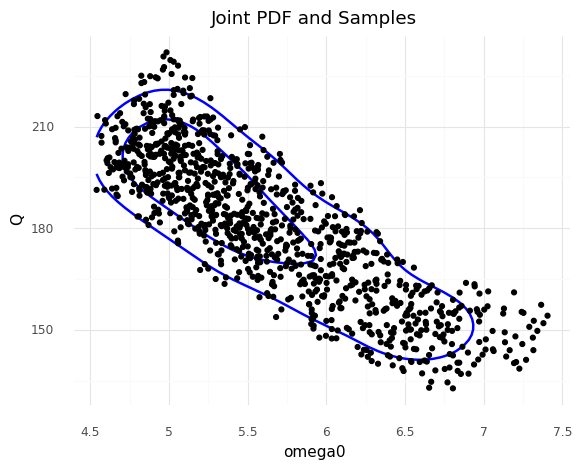

<ggplot: (8780395527597)>

In [17]:
p = (
    md_prlc
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", seed=101)
    
    >> ggplot(aes("omega0", "Q"))
    + geom_density_2d(color="blue", size=1)
    + geom_point()
    + theme_minimal()
    + labs(title="Joint PDF and Samples")
)
ggsave(p, "./images/q-omega0.png")
p

Here we can draw samples from this `Q, omega0` distribution by using our physical model. But in cases where we don't have such a "bottom-up" model, we need a different way model this kind of dependence.


## Strength-toughness example

There's no simple formula defining the relationship between strength and toughness, but clearly structural alloys exhibit a tradeoff between these properites. If we wanted to create a random variable model for these properties, we should represent the dependence between them.

![](https://upload.wikimedia.org/wikipedia/commons/a/a4/Fracture_toughness_vs._Strength.jpg)


# Definitions

---

We can use concepts from probability theory to represent dependence.


## Joint CDF

$$F_{X,Y}(x, y) = \mathbb{P}[X \leq x, Y \leq y],$$

## Joint PDF

$$f_{X, Y}(x, y) = \frac{\partial^2 F_{X, Y}}{\partial x \partial y}$$

### Contours of joint PDF



eval_monte_carlo() is rounding n...


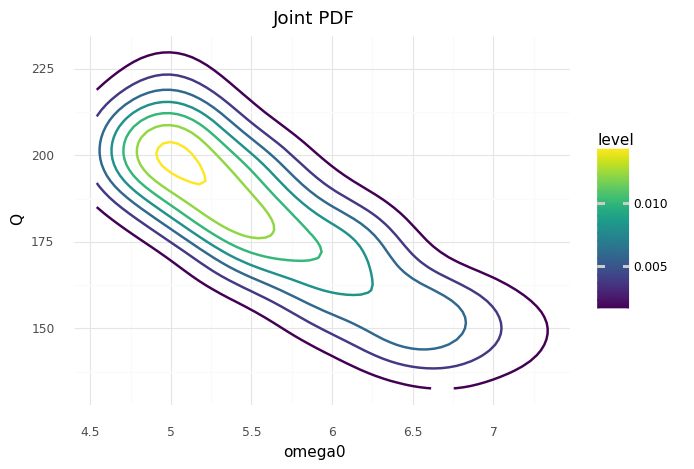

<ggplot: (8780396662697)>

In [28]:
(
    md_prlc
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", seed=101)
    
    >> ggplot(aes("omega0", "Q"))
    + geom_density_2d(
        mapping=aes(color="..level.."),
        size=1, 
        levels=10,
    )
    
    + theme_minimal()
    + labs(title="Joint PDF")
)

## Marginal distribution

Distribution where we "integrate out" all of the other variables:

$$F_X(x) = \int_y F_{X,Y}(x, y) dy$$

$$F_Y(y) = \int_x F_{X,Y}(x, y) dx$$


Notice with Grama that we define marginal distributions and a "copula". We'll get to copulas later, but for now know that you have flexibility in choosing the "shape" for each random variable.


## Independence

Two variables $X, Y$ are *independent* if their joint CDF factors:

$$F(x, y) = F_X(x) F_Y(y)$$


## Covariance

$$\text{Cov}[X, Y] = \mathbb{E}[(X - \mu_X)(Y - \mu_Y)]$$


## Correlation

A specific measure of dependence

$$\rho_{X, Y} = \frac{\text{Cov}[X,Y]}{\sigma_X \sigma_Y}$$


## Important caveat!

A lack of correlation does **not** mean a lack of dependence. The following data have exactly zero correlation, but clearly there's some dependence between the variables:


            rho
0  6.245005e-17


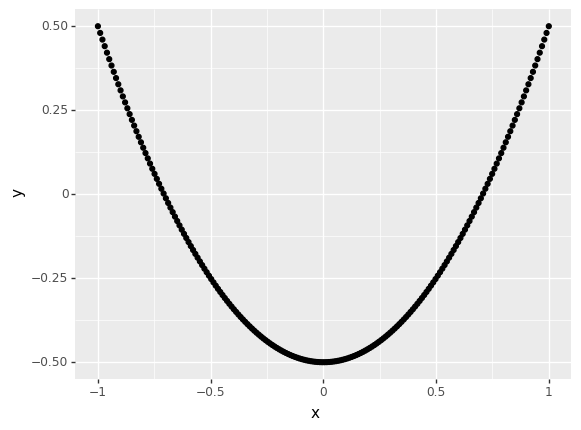

<ggplot: (8780396438781)>

In [33]:
df_quad = (
    gr.df_make(x=np.linspace(-1, +1, num=200))
    >> gr.tf_mutate(y=DF.x**2 - 0.5)
)

print(
    df_quad
    >> gr.tf_summarize(rho=gr.corr(DF.x, DF.y))
)

(
    df_quad
    >> ggplot(aes("x", "y"))
    + geom_point()
)

However, independence *does* imply zero covariance:

$$\text{Cov}[X, Y] = \int\int (x - \mu_X)(y - \mu_Y) f_{X,Y}(x, y) dx dy = \int\int (x - \mu_X)(y - \mu_Y) f_X(x) f_Y(y) dx dy = \mathbb{E}[X - \mu_X] \mathbb{E}[Y - \mu_Y] = 0$$

and hence zero correlation.
